# Adjust image brightness and contrast


## Problem

You need to fix inconsistent lighting across hundreds of images—adjusting brightness, contrast, and color saturation.


## Solution

**What's in this recipe:**
- Adjust brightness, contrast, and saturation
- Test adjustments before applying
- Process multiple images in batch

You adjust brightness, contrast, and saturation for images in your table using custom UDFs that wrap Pillow's `ImageEnhance` module (relies on PIL/Pillow). This lets you control enhancement levels to match your needs.

You can iterate on transformations before adding them to your table. Use `.select()` with `.collect()` to preview results on sample images—nothing is stored in your table. If you want to collect only the first few rows, use `.head(n)` instead of `.collect()`. Once you're satisfied, use `.add_computed_column()` to apply the adjustments to all images in your table.

For more on this workflow, see [Get fast feedback on transformations](./dev-iterative-workflow.ipynb).


### Setup


In [ ]:
%pip install -qU pixeltable

In [1]:
import pixeltable as pxt
from PIL import ImageEnhance

### Load images


In [2]:
# Create a fresh directory (drop existing if present)
pxt.drop_dir('image_demo', force=True)
pxt.create_dir('image_demo')

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/alison-pxt/.pixeltable/pgdata
Created directory 'image_demo'.


In [3]:
t = pxt.create_table('image_demo.enhancements', {'image': pxt.Image})

Created table 'enhancements'.


In [4]:
t.insert([
    {'image': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000001.jpg'},
    {'image': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000016.jpg'},
])

Inserting rows into `enhancements`: 2 rows [00:00, 698.64 rows/s]
Inserted 2 rows with 0 errors.


2 rows inserted, 4 values computed.

### Iterate: Adjust brightness and contrast for a few images first

In [4]:
@pxt.udf
def adjust_brightness(img: pxt.Image, factor: float) -> pxt.Image:
    """Adjust brightness. factor < 1 = darker, > 1 = brighter."""
    return ImageEnhance.Brightness(img).enhance(factor)

@pxt.udf
def adjust_contrast(img: pxt.Image, factor: float) -> pxt.Image:
    """Adjust contrast. factor < 1 = lower, > 1 = higher."""
    return ImageEnhance.Contrast(img).enhance(factor)

@pxt.udf
def adjust_saturation(img: pxt.Image, factor: float) -> pxt.Image:
    """Adjust saturation. factor < 1 = less saturated, > 1 = more saturated."""
    return ImageEnhance.Color(img).enhance(factor)

image,adjust_brightness,adjust_brightness_1
,,

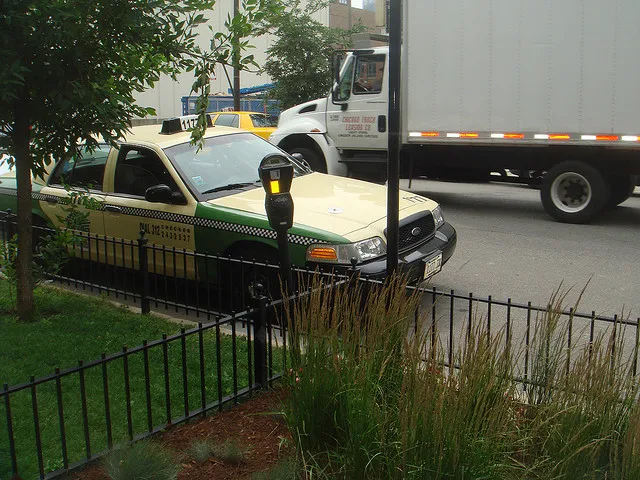
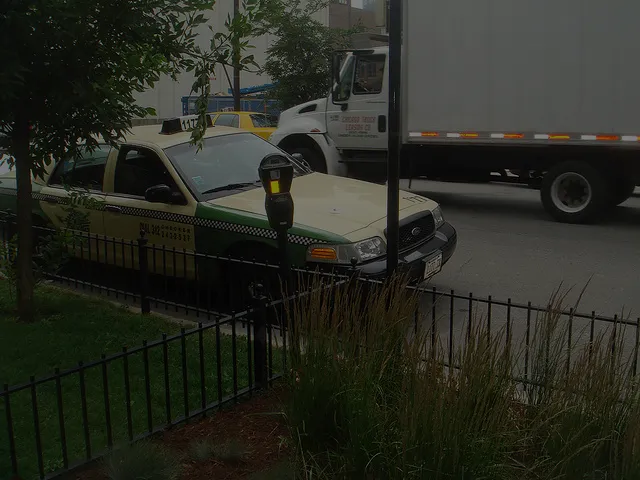
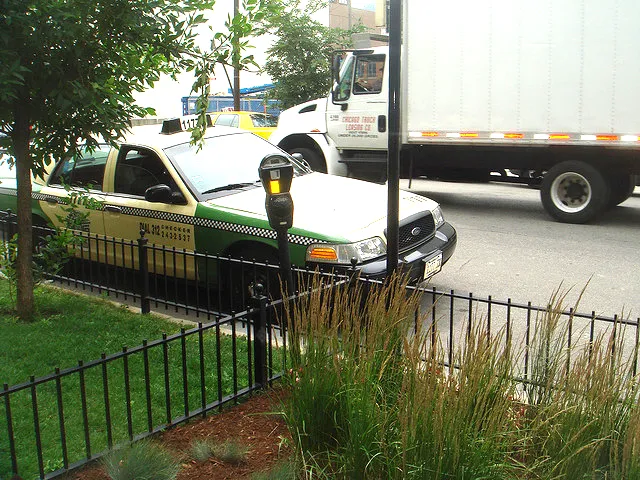

In [5]:
# Test brightness adjustments
t.select(
    t.image,
    adjust_brightness(t.image, 0.5),
    adjust_brightness(t.image, 1.5)
).head(1)

### Add: Adjust brightness and contrast for all images in your table

In [6]:
# Brightness adjustments (1.0 = original)
t.add_computed_column(darker=adjust_brightness(t.image, 0.5))
t.add_computed_column(brighter=adjust_brightness(t.image, 1.5))

# Contrast adjustments
t.add_computed_column(low_contrast=adjust_contrast(t.image, 0.5))
t.add_computed_column(high_contrast=adjust_contrast(t.image, 2.0))

# Color saturation
t.add_computed_column(desaturated=adjust_saturation(t.image, 0.3))
t.add_computed_column(saturated=adjust_saturation(t.image, 2.0))

Added 2 column values with 0 errors.
Added 2 column values with 0 errors.
Added 2 column values with 0 errors.
Added 2 column values with 0 errors.
Added 2 column values with 0 errors.
Added 2 column values with 0 errors.


2 rows updated, 2 values computed.

### View results

Compare different enhancement levels side-by-side.


image,darker,brighter
,,
,,

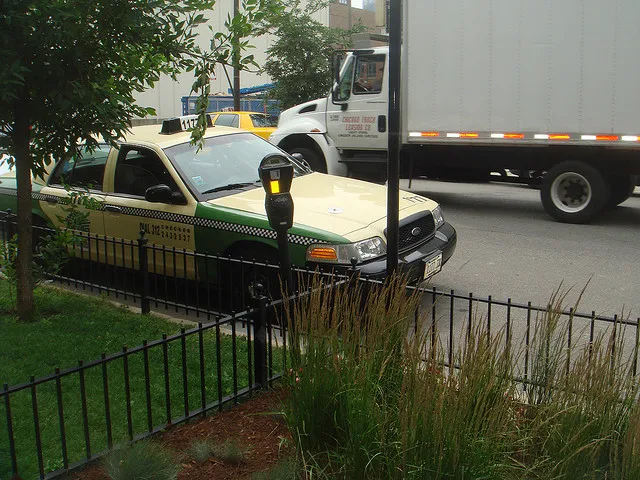
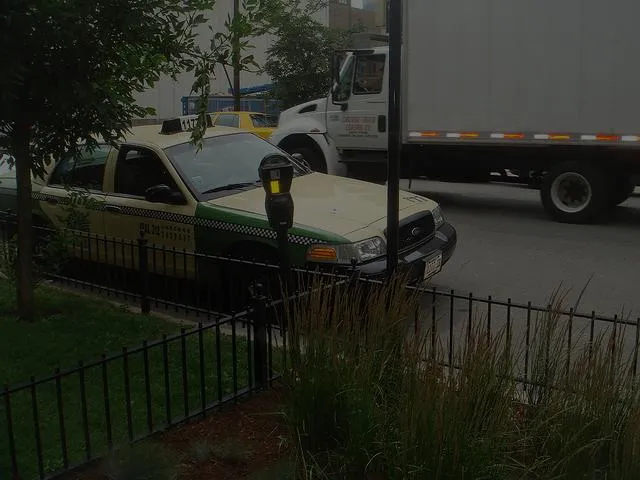
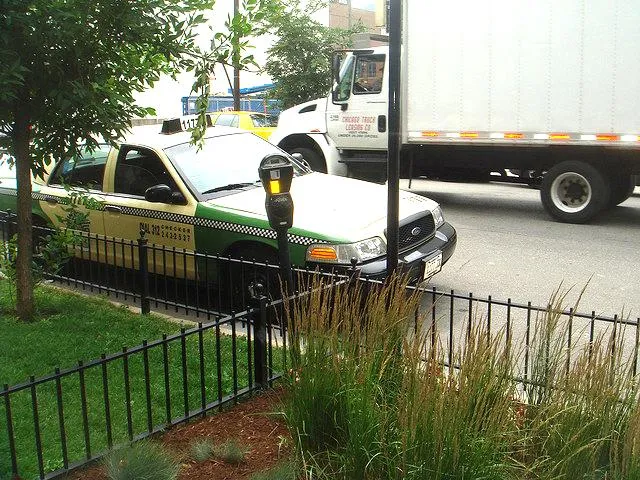
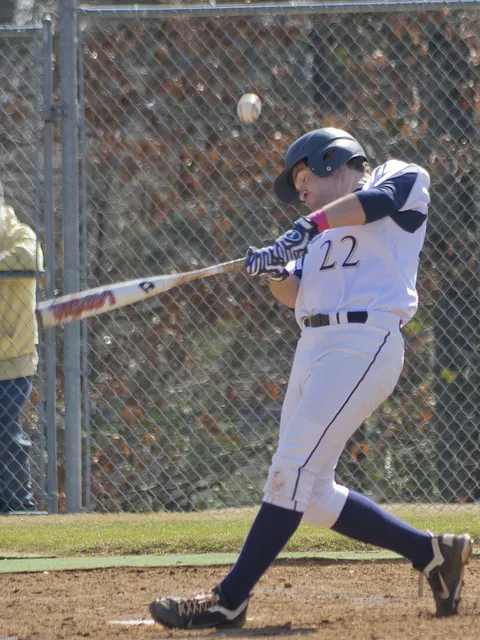
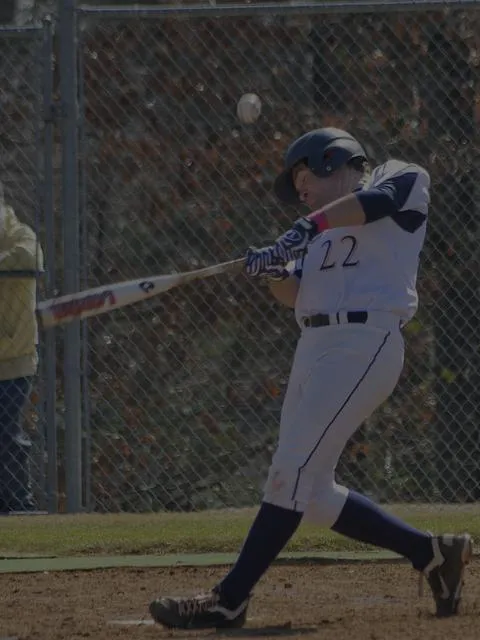
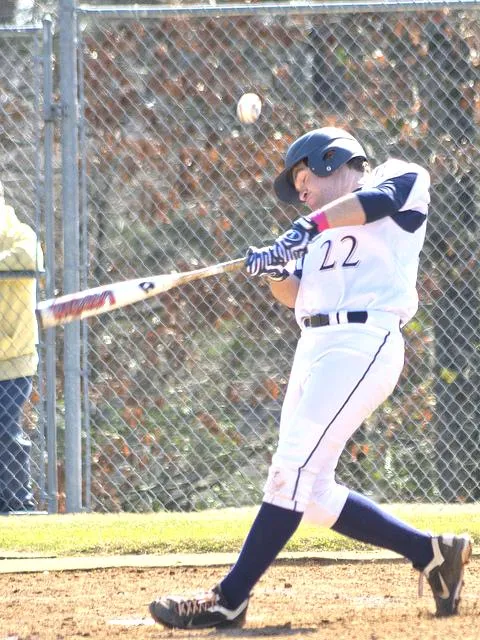

In [7]:
# Compare brightness levels
t.select(t.image, t.darker, t.brighter).collect()

image,low_contrast,high_contrast
,,
,,

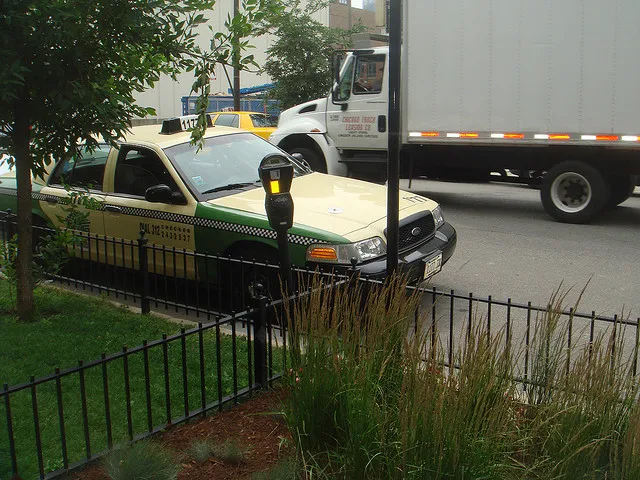
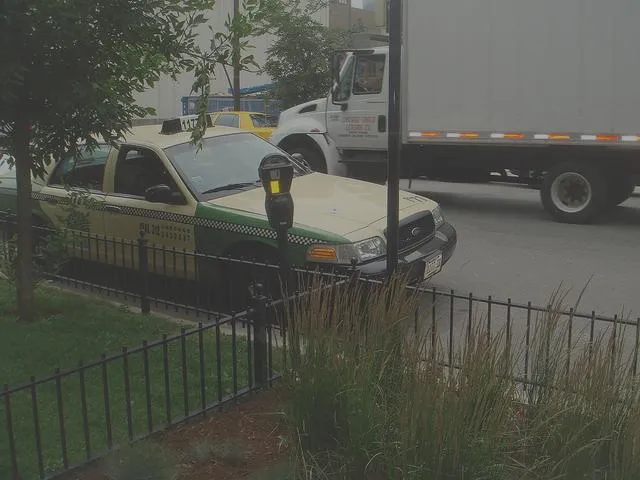
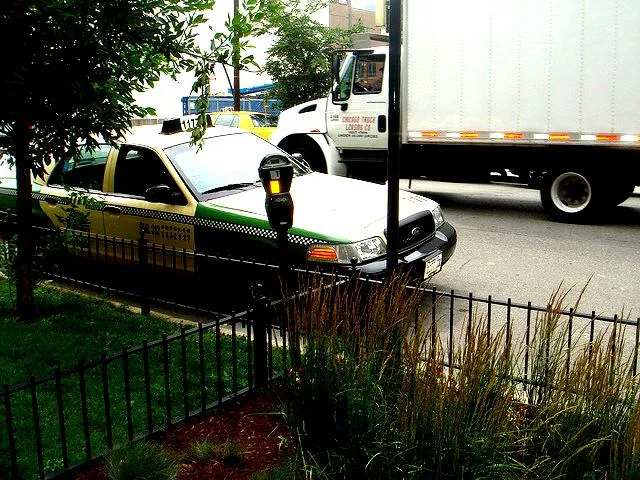
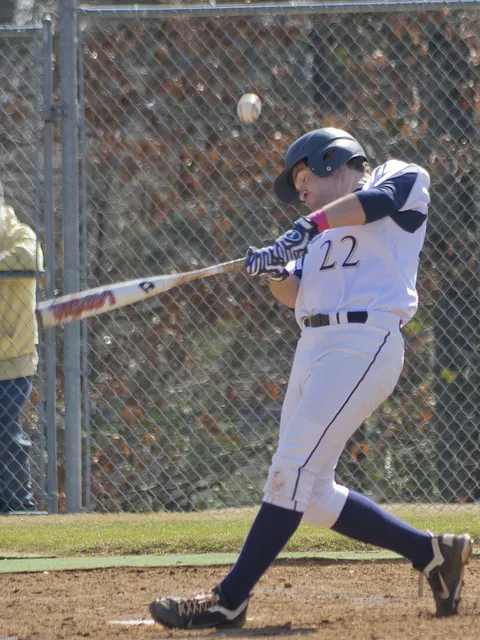
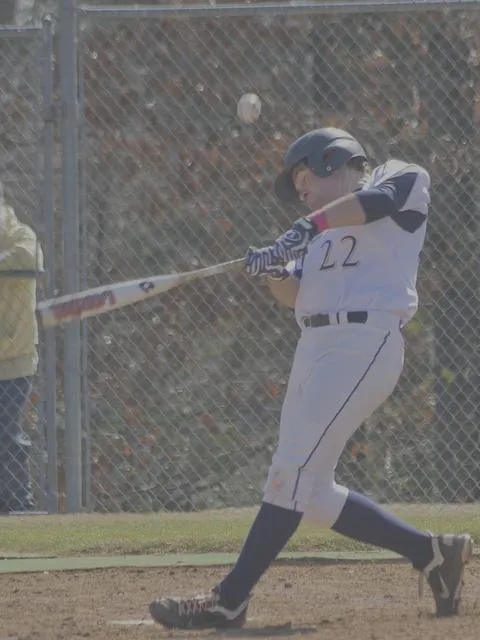
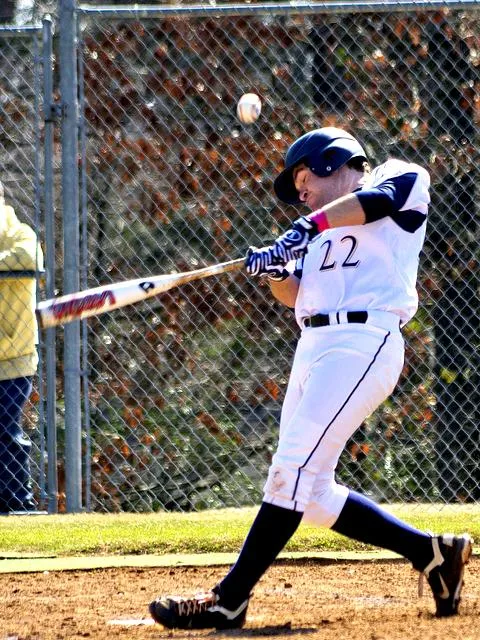

In [8]:
# Compare contrast levels
t.select(t.image, t.low_contrast, t.high_contrast).collect()

image,desaturated,saturated
,,
,,

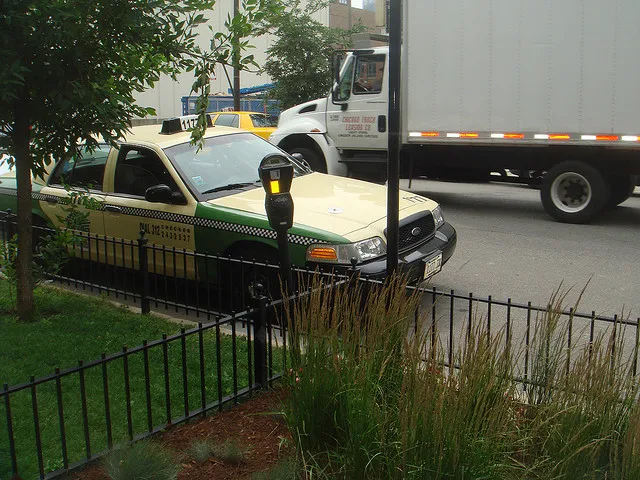
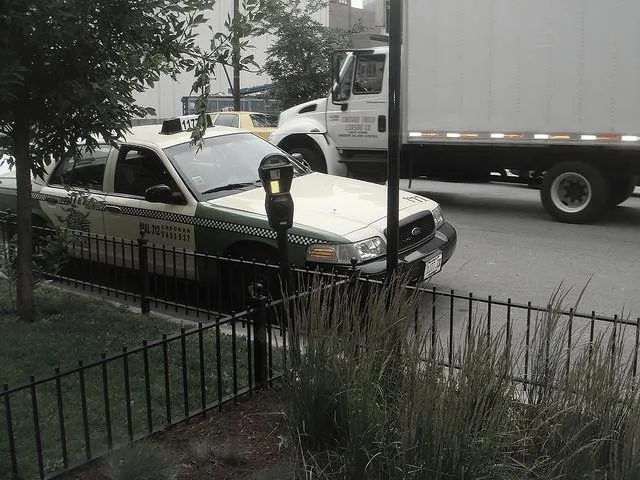
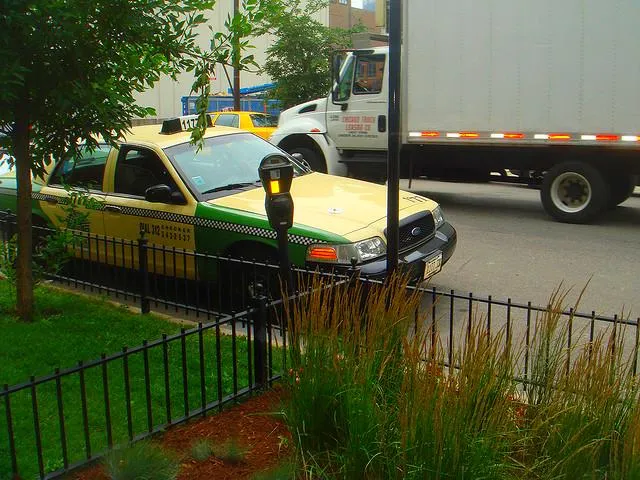
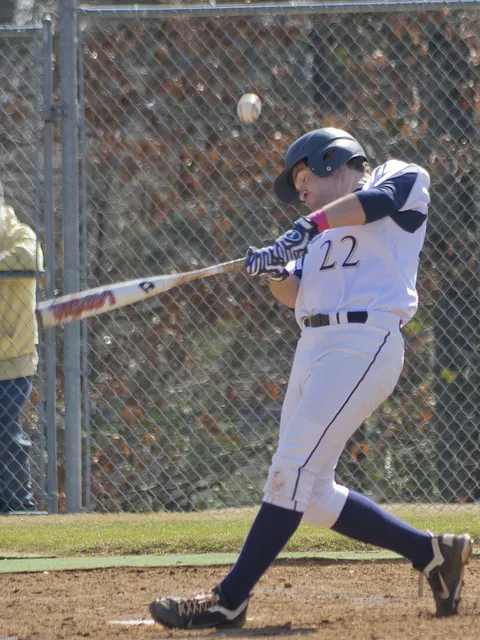
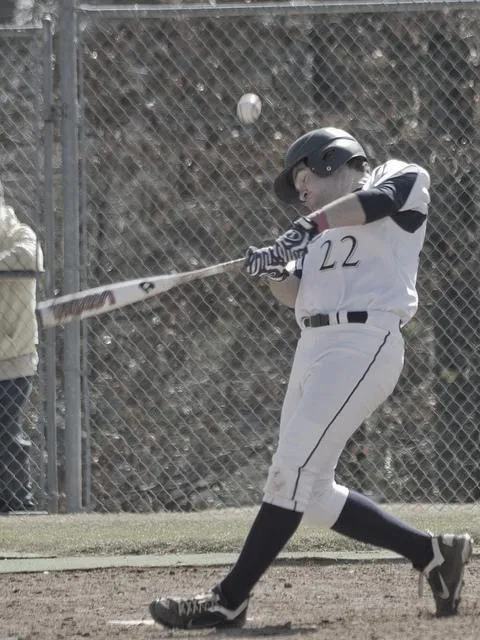
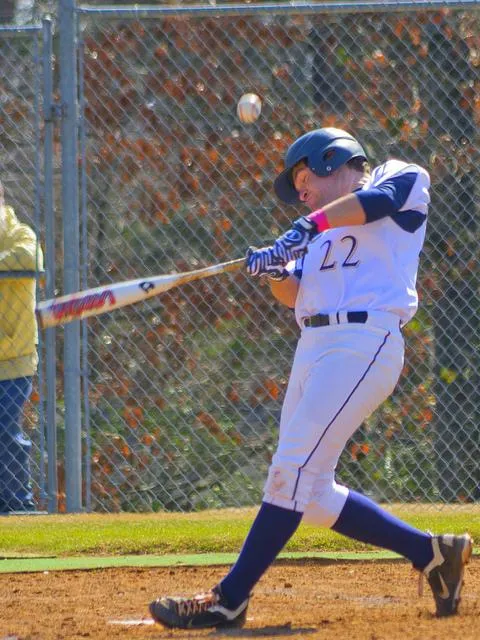

In [ ]:
# Compare saturation levels
t.select(t.image, t.desaturated, t.saturated).collect()

## Explanation

**How the enhancement technique works:**

The UDFs wrap PIL's `ImageEnhance` module to adjust visual properties of images. Each enhancement type creates an enhancer object for the image, then applies a multiplication factor. A factor of 1.0 leaves the image unchanged, values below 1.0 decrease the property (darker, less contrast, desaturated), and values above 1.0 increase it (brighter, more contrast, saturated). You can apply different factors to the same image to create multiple variations for comparison or different use cases.

**To customize the UDFs:**
- **Brightness factors**: Use 0.5 for darker images, 1.5 for brighter, or adjust to match your lighting needs
- **Contrast factors**: Use 0.5 for lower contrast, 2.0 for higher contrast, or fine-tune for image clarity
- **Saturation factors**: Use 0.3 for desaturated/muted colors, 2.0 for vibrant colors, or 0.0 for complete grayscale
- **Combine adjustments**: Apply multiple enhancements to create complex transformations

**The Pixeltable workflow:**

In traditional databases, `.select()` just picks which columns to view. In Pixeltable, `.select()` also lets you compute new transformations on the fly—define new columns without storing them. This makes `.select()` perfect for testing transformations before you commit them.

When you use `.select()`, you're creating a query that doesn't execute until you call `.collect()`. You must use `.collect()` to execute the query and return results—nothing is stored in your table. If you want to collect only the first few rows, use `.head(n)` instead of `.collect()` to test on a subset before processing your full dataset. Once satisfied, use `.add_computed_column()` with the same expression to persist results permanently.

For more on this workflow, see [Get fast feedback on transformations](./dev-iterative-workflow.ipynb).


## See also

- [Test transformations with fast feedback loops](./dev-iterative-workflow.ipynb)
- [Apply image filters](./img-apply-filters.ipynb)
- *Pillow techniques from [Real Python: Image Processing With the Python Pillow Library](https://realpython.com/image-processing-with-the-python-pillow-library/)*
